In [1]:
#导入表格数据
import pandas as pd
df=pd.read_excel('C:\\Users\\hp\\Desktop\\keshe\\material embedding.xlsx')

In [2]:
# 对 MEA_configuration 列进行 one-hot 编码
one_hot_encoded_MEA_configuration = pd.get_dummies(df['MEA_configuration'])
# 将 one-hot 编码后的结果合并到原数据框
df = pd.concat([df, one_hot_encoded_MEA_configuration], axis=1)

# 对 electrolyte_2 列进行 one-hot 编码
one_hot_encoded_electrolyte_2 = pd.get_dummies(df['electrolyte_2'])
# 将 one-hot 编码后的结果合并到原数据框
df = pd.concat([df, one_hot_encoded_electrolyte_2], axis=1)

# 对 membrane 列进行 one-hot 编码
one_hot_encoded_membrane = pd.get_dummies(df['membrane'])
# 将 one-hot 编码后的结果合并到原数据框
df = pd.concat([df, one_hot_encoded_membrane], axis=1)

# 对 anode 列进行 one-hot 编码
one_hot_encoded_anode = pd.get_dummies(df['anode'])
# 将 one-hot 编码后的结果合并到原数据框
df = pd.concat([df, one_hot_encoded_anode], axis=1)

随机森林模型的混淆矩阵图：


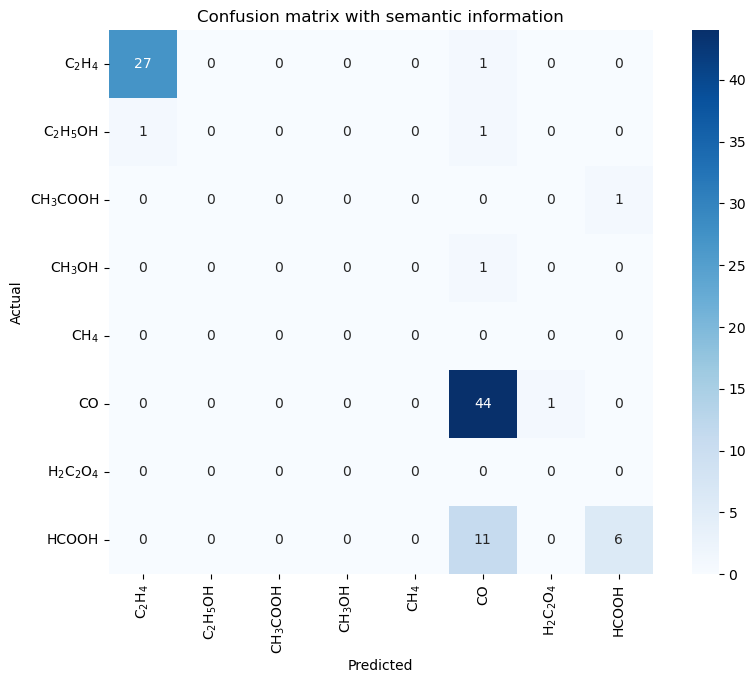

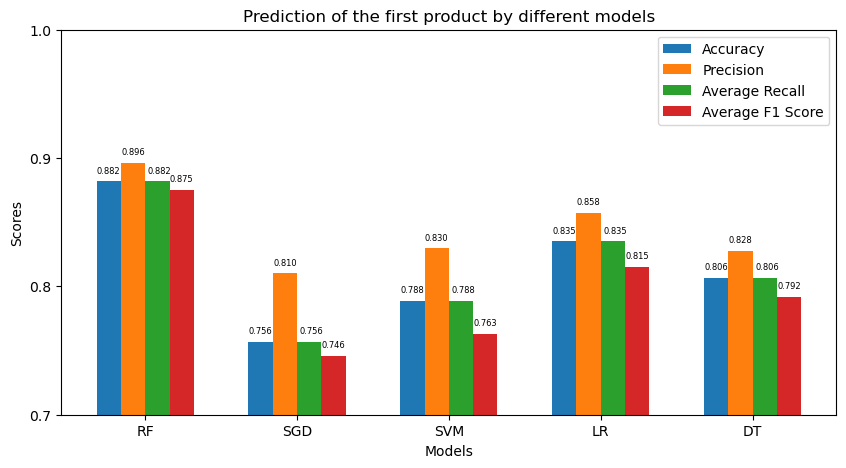

各模型评估指标如下：
RF模型：
    准确率: 0.8817532467532467
    精确率: 0.8959252250415167
    召回率: 0.8817532467532467
    F1值: 0.8752229849108923
SGD模型：
    准确率: 0.7564285714285715
    精确率: 0.8101924607787779
    召回率: 0.7564285714285715
    F1值: 0.7460788041600769
SVM模型：
    准确率: 0.7884415584415585
    精确率: 0.8295702651690047
    召回率: 0.7884415584415585
    F1值: 0.7629073154372688
LR模型：
    准确率: 0.8351298701298701
    精确率: 0.857546276086192
    召回率: 0.8351298701298701
    F1值: 0.8151772747979926
DT模型：
    准确率: 0.8063636363636364
    精确率: 0.8278320898091716
    召回率: 0.8063636363636364
    F1值: 0.7915883529225801


In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

embedding_columns = ['Material']
bool_column = ['copper_containing']

# 定义特征列和目标列
X = df[embedding_columns + bool_column + list(one_hot_encoded_MEA_configuration.columns) + list(one_hot_encoded_anode.columns)  
               + list(one_hot_encoded_electrolyte_2.columns) + list(one_hot_encoded_membrane.columns) + ['voltage', 'electrolyte_flow_anolyte_rate',
                                                              'CO2_flow_rate', 'MEA_area', 'membrane_area', 'anode_area',
                                                               'anode_catalyst_loading', 'cathode_area',
                                                               'cathode_catalyst_loading', 'temperature', 'electrolyte_1']]
y = df['first_product']

# 对目标列进行编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 划分训练集和测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_encoded, train_size=0.75, test_size=0.25, random_state=42)
# 用于存储不同模型的评估指标结果
model_results = {}

# 随机森林模型
rf_model = RandomForestClassifier(random_state=42)
kf_rf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_rf = []
precision_scores_rf = []
recall_scores_rf = []
f1_scores_rf = []

for train_index, val_index in kf_rf.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)

    accuracy_scores_rf.append(accuracy_score(y_val, y_pred))
    precision_scores_rf.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_rf.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_rf.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['RF'] = {
    'accuracy': np.mean(accuracy_scores_rf),
    'precision': np.mean(precision_scores_rf),
    'recall': np.mean(recall_scores_rf),
    'f1_score': np.mean(f1_scores_rf)
}

# 绘制随机森林模型的混淆矩阵图
print("随机森林模型的混淆矩阵图：")
y_pred_test = rf_model.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_test)

# 获取所有可能的标签
all_labels = label_encoder.classes_

# 定义一个函数将普通化学式字符串转换为 LaTeX 格式
def convert_to_latex(formula):
    import re
    # 匹配数字并在前面添加 _ 以实现下标
    return re.sub(r'(\d+)', r'$_{\1}$', formula)

# 将所有标签转换为 LaTeX 格式
latex_labels = [convert_to_latex(label) for label in all_labels]

# 创建一个全0的DataFrame，索引和列名为所有可能的标签
conf_matrix_df = pd.DataFrame(0, index=latex_labels, columns=latex_labels)

# 填充实际的混淆矩阵值
for true_encoded, pred_encoded in zip(y_test, y_pred_test):
    true_label = label_encoder.inverse_transform([true_encoded])[0]
    pred_label = label_encoder.inverse_transform([pred_encoded])[0]
    true_latex_label = convert_to_latex(true_label)
    pred_latex_label = convert_to_latex(pred_label)
    conf_matrix_df.loc[true_latex_label, pred_latex_label] += 1

# 绘制混淆矩阵的热力图
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues',square=True)
# 设置 x 轴标签旋转 90 度，变为纵向显示
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# 设置 y 轴标签旋转 0 度，变为横向显示
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.gcf().subplots_adjust(bottom=0.2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix with semantic information')
plt.savefig('J列语义混淆矩阵.jpg',dpi=3000)
plt.show()

# 输出随机森林真实值预测值的表格
result_df_rf = pd.DataFrame({
    'True_Values': label_encoder.inverse_transform(y_test),
    'Predicted_Values': label_encoder.inverse_transform(y_pred_test)
})
result_df_rf.to_excel('Jesult_table.xlsx', index=False)

# SGDClassifier模型
sgd_model = SGDClassifier(random_state=42)
kf_sgd = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_sgd = []
precision_scores_sgd = []
recall_scores_sgd = []
f1_scores_sgd = []

for train_index, val_index in kf_sgd.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    sgd_model.fit(X_train, y_train)
    y_pred = sgd_model.predict(X_val)

    accuracy_scores_sgd.append(accuracy_score(y_val, y_pred))
    precision_scores_sgd.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_sgd.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_sgd.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['SGD'] = {
    'accuracy': np.mean(accuracy_scores_sgd),
    'precision': np.mean(precision_scores_sgd),
    'recall': np.mean(recall_scores_sgd),
    'f1_score': np.mean(f1_scores_sgd)
}

# SVM模型
svm_model = SVC(random_state=42)
kf_svm = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_svm = []
precision_scores_svm = []
recall_scores_svm = []
f1_scores_svm = []

for train_index, val_index in kf_svm.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_val)

    accuracy_scores_svm.append(accuracy_score(y_val, y_pred))
    precision_scores_svm.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_svm.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_svm.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['SVM'] = {
    'accuracy': np.mean(accuracy_scores_svm),
    'precision': np.mean(precision_scores_svm),
    'recall': np.mean(recall_scores_svm),
    'f1_score': np.mean(f1_scores_svm)
}

# 逻辑回归模型
logistic_model = LogisticRegression(random_state=42)
kf_logistic = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_logistic = []
precision_scores_logistic = []
recall_scores_logistic = []
f1_scores_logistic = []

for train_index, val_index in kf_logistic.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_val)

    accuracy_scores_logistic.append(accuracy_score(y_val, y_pred))
    precision_scores_logistic.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_logistic.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_logistic.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['LR'] = {
    'accuracy': np.mean(accuracy_scores_logistic),
    'precision': np.mean(precision_scores_logistic),
    'recall': np.mean(recall_scores_logistic),
    'f1_score': np.mean(f1_scores_logistic)
}

# 决策树模型
# 添加控制决策树复杂度的参数，防止过拟合
decision_tree_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5, min_samples_split=10)
kf_decision_tree = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_decision_tree = []
precision_scores_decision_tree = []
recall_scores_decision_tree = []
f1_scores_decision_tree = []

for train_index, val_index in kf_decision_tree.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    decision_tree_model.fit(X_train, y_train)
    y_pred = decision_tree_model.predict(X_val)

    accuracy_scores_decision_tree.append(accuracy_score(y_val, y_pred))
    precision_scores_decision_tree.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_decision_tree.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_decision_tree.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['DT'] = {
    'accuracy': np.mean(accuracy_scores_decision_tree),
    'precision': np.mean(precision_scores_decision_tree),
    'recall': np.mean(recall_scores_decision_tree),
    'f1_score': np.mean(f1_scores_decision_tree)
}

# 提取每个模型的评估指标用于绘制柱状图
models = list(model_results.keys())
accuracies = [model_results[model]['accuracy'] for model in models]
precisions = [model_results[model]['precision'] for model in models]
recalls = [model_results[model]['recall'] for model in models]
f1_scores = [model_results[model]['f1_score'] for model in models]

# 设置柱状图的宽度
bar_width = 0.20


# 设置柱状图的位置索引，拉大模型之间的距离
index = np.arange(len(models)) * 1.25

# 设置图表尺寸
fig, ax = plt.subplots(figsize=(10, 5))
# 绘制柱状图
plt.bar(index - bar_width * 1.5, accuracies, width=bar_width, label='Accuracy')
plt.bar(index - bar_width * 0.5, precisions, width=bar_width, label='Precision')
plt.bar(index + bar_width * 0.5, recalls, width=bar_width, label='Average Recall')
plt.bar(index + bar_width * 1.5, f1_scores, width=bar_width, label='Average F1 Score')

# 在每个柱子上方添加数值显示
for i, value in enumerate(accuracies):
    bar_index = index[i] - bar_width * 2 + bar_width / 2 
    plt.text(bar_index, value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=6)

for i, value in enumerate(precisions):
    bar_index = index[i] - bar_width + bar_width / 2
    plt.text(bar_index, value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=6)

for i, value in enumerate(recalls):
    bar_index = index[i] + bar_width *0.1 + bar_width / 2
    plt.text(bar_index, value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=6)

for i, value in enumerate(f1_scores):
    bar_index = index[i] + bar_width * 1 + bar_width / 2
    plt.text(bar_index, value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=6)

# 设置x轴标签和刻度
plt.xlabel('Models')
plt.xticks(index, models)

# 设置y轴标签
plt.ylabel('Scores')
# 设置y轴刻度范围
plt.ylim(0.7, 1.0)
plt.yticks(np.arange(0.7, 1.01, 0.1))
# 设置图例
plt.legend()

# 设置图表标题
plt.title('Prediction of the first product by different models')
plt.savefig('J列模型对比.jpg',dpi=1000)
# 显示图表
plt.show()

# 输出每种模型的各项评估指标
print("各模型评估指标如下：")
for model in models:
    print(f"{model}模型：")
    print(f"    准确率: {model_results[model]['accuracy']}")
    print(f"    精确率: {model_results[model]['precision']}")
    print(f"    召回率: {model_results[model]['recall']}")
    print(f"    F1值: {model_results[model]['f1_score']}")

In [4]:
df['first_product_faraday_efficiency'] = df['first_product_faraday_efficiency'] / 100

各模型评估指标如下：
Lasso模型：
    决定系数（R2）: 0.40602194161682154
    均方误差（MSE）: 0.03575127902824039
    平均绝对误差（MAE）: 0.14459063900050828
RF模型：
    决定系数（R2）: 0.5903155971670528
    均方误差（MSE）: 0.02474827153798923
    平均绝对误差（MAE）: 0.11652252435606066
GB模型：
    决定系数（R2）: 0.5425740646211086
    均方误差（MSE）: 0.027652500172179545
    平均绝对误差（MAE）: 0.12495147623363027
DT模型：
    决定系数（R2）: 0.38378492754439886
    均方误差（MSE）: 0.0372834104887987
    平均绝对误差（MAE）: 0.1359318603896104
Ridge模型：
    决定系数（R2）: 0.40333059214296424
    均方误差（MSE）: 0.03596310962160861
    平均绝对误差（MAE）: 0.14578262430385341
随机森林拟合直线方程为：y = 0.60722x + 0.24848
随机森林模型的R2值为：0.59032


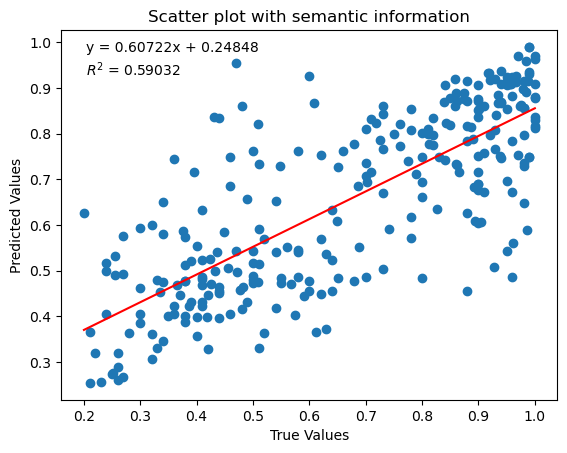

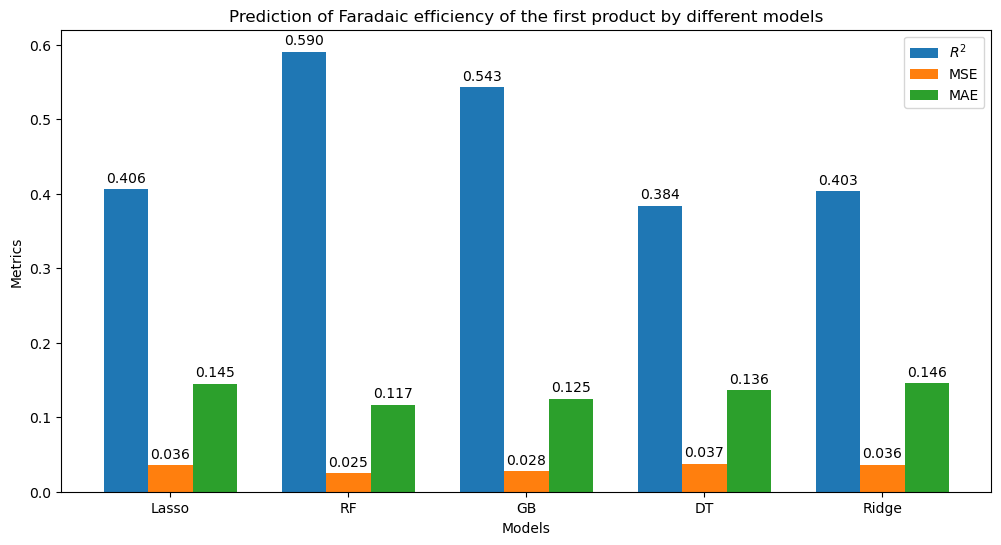

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

embedding_columns = ['Material']
bool_column = ['copper_containing']
le = LabelEncoder()
df['fp_encoded'] = le.fit_transform(df['first_product'])

# 定义特征列和目标列
X = df[embedding_columns + bool_column + list(one_hot_encoded_MEA_configuration.columns) + list(one_hot_encoded_anode.columns)
               + list(one_hot_encoded_electrolyte_2.columns) + list(one_hot_encoded_membrane.columns)
                                                               + ['voltage', 'electrolyte_flow_anolyte_rate', 'CO2_flow_rate',
                                                               'MEA_area', 'membrane_area', 'anode_area',
                                                               'anode_catalyst_loading', 'cathode_area',
                                                               'cathode_catalyst_loading', 'temperature', 'electrolyte_1', 'fp_encoded']]
y = df['first_product_faraday_efficiency']

# 划分训练集和测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42)

# 初始化K折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 用于存储不同模型的评估指标结果
r2_results = {}
mse_results = {}
mae_results = {}
# 用于存储各模型每次验证集的真实值和预测值
all_true_values_dict = {}
all_predicted_values_dict = {}

# Lasso回归模型
def lasso_model():
    # 定义参数网格
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

    # 创建Lasso回归模型
    lasso = Lasso()

    # 创建网格搜索对象
    grid_search = GridSearchCV(lasso, param_grid, cv=kf, scoring='r2')

    # 进行网格搜索
    grid_search.fit(X_trainval, y_trainval)

    # 获取最优的模型
    best_lasso = grid_search.best_estimator_

    # 重新计算评估指标
    lasso_mse_scores = []
    lasso_r2_scores = []
    lasso_mae_scores = []
    for train_index, val_index in kf.split(X_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        best_lasso.fit(X_train, y_train)
        y_val_pred = best_lasso.predict(X_val)
        lasso_mse_scores.append(mean_squared_error(y_val, y_val_pred))
        lasso_r2_scores.append(r2_score(y_val, y_val_pred))
        lasso_mae_scores.append(mean_absolute_error(y_val, y_val_pred))

    r2_results['Lasso'] = np.mean(lasso_r2_scores)
    mse_results['Lasso'] = np.mean(lasso_mse_scores)
    mae_results['Lasso'] = np.mean(lasso_mae_scores)
    return best_lasso

# 随机森林回归模型
def random_forest_model():
    rf_model = RandomForestRegressor(random_state=42)
    rf_mse_scores = []
    rf_r2_scores = []
    rf_mae_scores = []
    all_true_values_rf = []
    all_predicted_values_rf = []
    for train_index, val_index in kf.split(X_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        rf_model.fit(X_train, y_train)
        y_val_pred = rf_model.predict(X_val)
        rf_mse_scores.append(mean_squared_error(y_val, y_val_pred))
        rf_r2_scores.append(r2_score(y_val, y_val_pred))
        rf_mae_scores.append(mean_absolute_error(y_val, y_val_pred))
        all_true_values_rf.extend(y_val)
        all_predicted_values_rf.extend(y_val_pred)
    r2_results['RF'] = np.mean(rf_r2_scores)
    mse_results['RF'] = np.mean(rf_mse_scores)
    mae_results['RF'] = np.mean(rf_mae_scores)
    all_true_values_dict['RF'] = all_true_values_rf
    all_predicted_values_dict['RF'] = all_predicted_values_rf
    return rf_model

# 梯度提升回归模型
def gradient_boosting_model():
    gb_model = GradientBoostingRegressor(random_state=42)
    gb_mse_scores = []
    gb_r2_scores = []
    gb_mae_scores = []
    all_true_values_gb = []
    all_predicted_values_gb = []
    for train_index, val_index in kf.split(X_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        gb_model.fit(X_train, y_train)
        y_val_pred = gb_model.predict(X_val)
        gb_r2_scores.append(r2_score(y_val, y_val_pred))
        gb_mse_scores.append(mean_squared_error(y_val, y_val_pred))
        gb_mae_scores.append(mean_absolute_error(y_val, y_val_pred))
        all_true_values_gb.extend(y_val)
        all_predicted_values_gb.extend(y_val_pred)
    r2_results['GB'] = np.mean(gb_r2_scores)
    mse_results['GB'] = np.mean(gb_mse_scores)
    mae_results['GB'] = np.mean(gb_mae_scores)
    all_true_values_dict['GB'] = all_true_values_gb
    all_predicted_values_dict['GB'] = all_predicted_values_gb
    return gb_model

# 决策树回归模型
def decision_tree_model():
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_mse_scores = []
    dt_r2_scores = []
    dt_mae_scores = []
    all_true_values_dt = []
    all_predicted_values_dt = []
    for train_index, val_index in kf.split(X_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        dt_model.fit(X_train, y_train)
        y_val_pred = dt_model.predict(X_val)
        dt_r2_scores.append(r2_score(y_val, y_val_pred))
        dt_mse_scores.append(mean_squared_error(y_val, y_val_pred))
        dt_mae_scores.append(mean_absolute_error(y_val, y_val_pred))
        all_true_values_dt.extend(y_val)
        all_predicted_values_dt.extend(y_val_pred)
    r2_results['DT'] = np.mean(dt_r2_scores)
    mse_results['DT'] = np.mean(dt_mse_scores)
    mae_results['DT'] = np.mean(dt_mae_scores)
    all_true_values_dict['DT'] = all_true_values_dt
    all_predicted_values_dict['DT'] = all_predicted_values_dt
    return dt_model

# 岭回归模型
def ridge_model():
    ridge = Ridge()
    ridge_mse_scores = []
    ridge_r2_scores = []
    ridge_mae_scores = []
    all_true_values_ridge = []
    all_predicted_values_ridge = []
    for train_index, val_index in kf.split(X_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        ridge.fit(X_train, y_train)
        y_val_pred = ridge.predict(X_val)
        ridge_r2_scores.append(r2_score(y_val, y_val_pred))
        ridge_mse_scores.append(mean_squared_error(y_val, y_val_pred))
        ridge_mae_scores.append(mean_absolute_error(y_val, y_val_pred))
        all_true_values_ridge.extend(y_val)
        all_predicted_values_ridge.extend(y_val_pred)
    r2_results['Ridge'] = np.mean(ridge_r2_scores)
    mse_results['Ridge'] = np.mean(ridge_mse_scores)
    mae_results['Ridge'] = np.mean(ridge_mae_scores)
    all_true_values_dict['Ridge'] = all_true_values_ridge
    all_predicted_values_dict['Ridge'] = all_predicted_values_ridge
    return ridge

# 运行各个模型并收集结果
la_model = lasso_model()
rf_model = random_forest_model()
gb_model = gradient_boosting_model()
dt_model = decision_tree_model()
ridge_model = ridge_model()

# 输出每种模型的MSE、R2和MAE数值
print("各模型评估指标如下：")
for model in r2_results.keys():
    print(f"{model}模型：")
    print(f"    决定系数（R2）: {r2_results[model]}")
    print(f"    均方误差（MSE）: {mse_results[model]}")
    print(f"    平均绝对误差（MAE）: {mae_results[model]}")

# 以随机森林模型，将其验证集的真实值和预测值输出到Excel文件
result_df_rf = pd.DataFrame({
    'True_Values': all_true_values_dict['RF'],
    'Predicted_Values': all_predicted_values_dict['RF']
})
result_df_rf.to_excel('Kyuyiresult_table.xlsx', index=False)

# 以随机森林模型为例，绘制散点图及拟合直线（可按需对其他模型做同样操作）
# 将列表转换为numpy数组，便于后续计算
all_true_values_rf_np = np.array(all_true_values_dict['RF']).reshape(-1, 1)
all_predicted_values_rf_np = np.array(all_predicted_values_dict['RF']).reshape(-1, 1)

# 创建线性回归对象并拟合数据
reg = linear_model.LinearRegression()
reg.fit(all_true_values_rf_np, all_predicted_values_rf_np)

# 得到拟合直线的斜率和截距
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]

# 计算R2值
r2 = r2_results['RF']

# 输出拟合直线方程
print(f"随机森林拟合直线方程为：y = {slope:.5f}x + {intercept:.5f}")
print(f"随机森林模型的R2值为：{r2:.5f}")

# 绘制散点图
plt.scatter(all_true_values_rf_np, all_predicted_values_rf_np)

# 绘制拟合直线
x_vals = np.array([min(all_true_values_rf_np), max(all_true_values_rf_np)])
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red')

# 添加回归方程和R2值到图表
plt.text(0.05, 0.97, f"y = {slope:.5f}x + {intercept:.5f}", transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top')
plt.text(0.05, 0.92, f"$R^2$ = {r2:.5f}", transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter plot with semantic information')
plt.savefig('K列语义散点图.jpg', dpi=1000)
plt.show()

# 绘制柱状图展示不同模型的R2、MSE和MAE评估指标结果
models = list(r2_results.keys())
r2_values = list(r2_results.values())
mse_values = list(mse_results.values())
mae_values = list(mae_results.values())

bar_width = 0.25
r2_positions = np.arange(len(models))
mse_positions = [pos + bar_width for pos in r2_positions]
mae_positions = [pos + bar_width for pos in mse_positions]

# 设置图表尺寸
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制柱状图
r2_bars = plt.bar(r2_positions, r2_values, width=bar_width, label='$R^{2}$')
mse_bars = plt.bar(mse_positions, mse_values, width=bar_width, label='MSE')
mae_bars = plt.bar(mae_positions, mae_values, width=bar_width, label='MAE')

# 在柱状图上添加数值标签
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 调整数值标签的垂直偏移量
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(ax, r2_bars)
add_value_labels(ax, mse_bars)
add_value_labels(ax, mae_bars)

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Prediction of Faradaic efficiency of the first product by different models')
plt.xticks([pos + bar_width for pos in r2_positions], models)
plt.legend()
plt.savefig('K列模型对比.jpg', dpi=1000)
plt.show()

In [6]:
# 处理total_current_density列成为分类变量
def categorize_current(current):
    if 0 < current <= 100:
        return 'Category_1'
    elif 100 < current <= 180:
        return 'Category_2'
    elif 180 < current <= 1000:
        return 'Category_3'    
df['tcd_category'] = df['total_current_density'].apply(categorize_current)

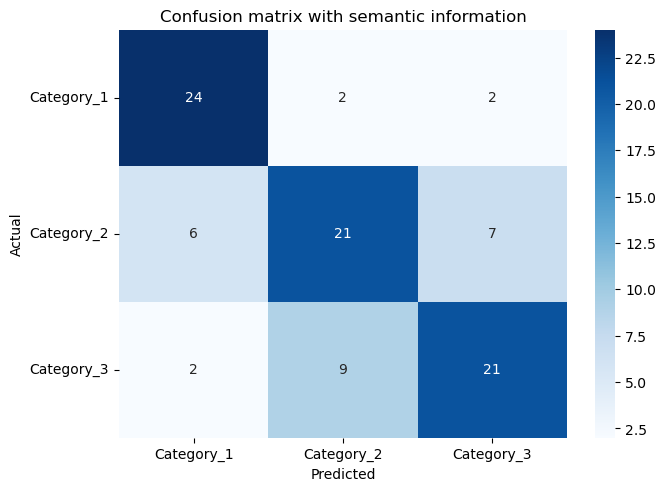

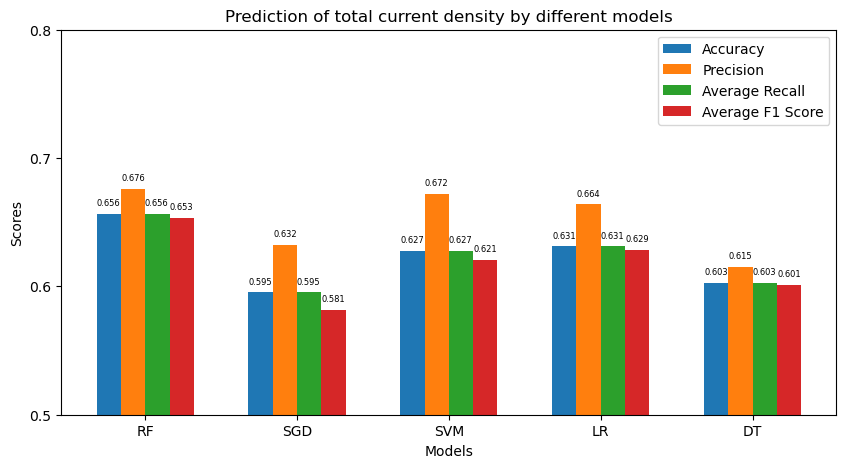

各模型评估指标如下：
RF模型：
    准确率: 0.6562337662337663
    精确率: 0.6757997213313004
    召回率: 0.6562337662337663
    F1值: 0.6534958015668482
SGD模型：
    准确率: 0.5952597402597404
    精确率: 0.6321756717162283
    召回率: 0.5952597402597404
    F1值: 0.581414996982234
SVM模型：
    准确率: 0.6274675324675324
    精确率: 0.6719720250720529
    召回率: 0.6274675324675324
    F1值: 0.6205210657693291
LR模型：
    准确率: 0.6311038961038961
    精确率: 0.6639528536953329
    召回率: 0.6311038961038961
    F1值: 0.6286318465948463
DT模型：
    准确率: 0.6026623376623378
    精确率: 0.6154636038625977
    召回率: 0.6026623376623378
    F1值: 0.6013320889875539


In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import shap

embedding_columns = ['Material']
bool_column = ['copper_containing']

# 定义特征列和目标列
X = df[embedding_columns + bool_column + list(one_hot_encoded_MEA_configuration.columns) + list(one_hot_encoded_anode.columns)  
               + list(one_hot_encoded_electrolyte_2.columns) + list(one_hot_encoded_membrane.columns) + ['voltage', 'electrolyte_flow_anolyte_rate',
                                                              'CO2_flow_rate','MEA_area', 'membrane_area', 'anode_area',
                                                               'anode_catalyst_loading', 'cathode_area',
                                                               'cathode_catalyst_loading', 'temperature', 'electrolyte_1']]
y = df['tcd_category']

# 对目标列进行编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 划分训练集和测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_encoded, train_size=0.75, test_size=0.25, random_state=42)
# 用于存储不同模型的评估指标结果
model_results = {}

# 随机森林模型
rf_model = RandomForestClassifier(random_state=42)
kf_rf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_rf = []
precision_scores_rf = []
recall_scores_rf = []
f1_scores_rf = []

for train_index, val_index in kf_rf.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)

    accuracy_scores_rf.append(accuracy_score(y_val, y_pred))
    precision_scores_rf.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_rf.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_rf.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['RF'] = {
    'accuracy': np.mean(accuracy_scores_rf),
    'precision': np.mean(precision_scores_rf),
    'recall': np.mean(recall_scores_rf),
    'f1_score': np.mean(f1_scores_rf)
}
# 在测试集上评估并绘制混淆矩阵
y_pred_test = rf_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

# 创建包含真实值和预测值的数据框
result_df = pd.DataFrame({
    'True_Label': label_encoder.inverse_transform(y_test),  # 将编码后的真实值转换回原始类别
    'Predicted_Label': label_encoder.inverse_transform(y_pred_test)  # 将预测值转换回原始类别
})

# 将数据框输出为Excel文件
result_df.to_excel('Qyuyiresult_table.xlsx', index=False)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion matrix with semantic information')
# 设置y轴标签水平显示
plt.yticks(rotation=0)
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Q列语义混淆矩阵.jpg',dpi=1000)
plt.show()

# SGDClassifier模型
sgd_model = SGDClassifier(random_state=42)
kf_sgd = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_sgd = []
precision_scores_sgd = []
recall_scores_sgd = []
f1_scores_sgd = []

for train_index, val_index in kf_sgd.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    sgd_model.fit(X_train, y_train)
    y_pred = sgd_model.predict(X_val)

    accuracy_scores_sgd.append(accuracy_score(y_val, y_pred))
    precision_scores_sgd.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_sgd.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_sgd.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['SGD'] = {
    'accuracy': np.mean(accuracy_scores_sgd),
    'precision': np.mean(precision_scores_sgd),
    'recall': np.mean(recall_scores_sgd),
    'f1_score': np.mean(f1_scores_sgd)
}

# SVM模型
svm_model = SVC(random_state=42)
kf_svm = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_svm = []
precision_scores_svm = []
recall_scores_svm = []
f1_scores_svm = []

for train_index, val_index in kf_svm.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_val)

    accuracy_scores_svm.append(accuracy_score(y_val, y_pred))
    precision_scores_svm.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_svm.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_svm.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['SVM'] = {
    'accuracy': np.mean(accuracy_scores_svm),
    'precision': np.mean(precision_scores_svm),
    'recall': np.mean(recall_scores_svm),
    'f1_score': np.mean(f1_scores_svm)
}
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# 逻辑回归模型
logistic_model = LogisticRegression(random_state=42)
kf_logistic = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_logistic = []
precision_scores_logistic = []
recall_scores_logistic = []
f1_scores_logistic = []

for train_index, val_index in kf_logistic.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_val)

    accuracy_scores_logistic.append(accuracy_score(y_val, y_pred))
    precision_scores_logistic.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_logistic.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_logistic.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['LR'] = {
    'accuracy': np.mean(accuracy_scores_logistic),
    'precision': np.mean(precision_scores_logistic),
    'recall': np.mean(recall_scores_logistic),
    'f1_score': np.mean(f1_scores_logistic)
}

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# 决策树模型
decision_tree_model = DecisionTreeClassifier(random_state=42)
kf_decision_tree = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores_decision_tree = []
precision_scores_decision_tree = []
recall_scores_decision_tree = []
f1_scores_decision_tree = []

for train_index, val_index in kf_decision_tree.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    decision_tree_model.fit(X_train, y_train)
    y_pred = decision_tree_model.predict(X_val)

    accuracy_scores_decision_tree.append(accuracy_score(y_val, y_pred))
    precision_scores_decision_tree.append(precision_score(y_val, y_pred, average='weighted', zero_division=1))
    recall_scores_decision_tree.append(recall_score(y_val, y_pred, average='weighted', zero_division=1))
    f1_scores_decision_tree.append(f1_score(y_val, y_pred, average='weighted', zero_division=1))

model_results['DT'] = {
    'accuracy': np.mean(accuracy_scores_decision_tree),
    'precision': np.mean(precision_scores_decision_tree),
    'recall': np.mean(recall_scores_decision_tree),
    'f1_score': np.mean(f1_scores_decision_tree)
}

# 提取每个模型的评估指标用于绘制柱状图
models = list(model_results.keys())
accuracies = [model_results[model]['accuracy'] for model in models]
precisions = [model_results[model]['precision'] for model in models]
recalls = [model_results[model]['recall'] for model in models]
f1_scores = [model_results[model]['f1_score'] for model in models]

# 设置柱状图的宽度
bar_width = 0.20


# 设置柱状图的位置索引，拉大模型之间的距离
index = np.arange(len(models)) * 1.25

# 设置图表尺寸
fig, ax = plt.subplots(figsize=(10, 5))
# 绘制柱状图
plt.bar(index - bar_width * 1.5, accuracies, width=bar_width, label='Accuracy')
plt.bar(index - bar_width * 0.5, precisions, width=bar_width, label='Precision')
plt.bar(index + bar_width * 0.5, recalls, width=bar_width, label='Average Recall')
plt.bar(index + bar_width * 1.5, f1_scores, width=bar_width, label='Average F1 Score')

# 在每个柱子上方添加数值显示
for i, value in enumerate(accuracies):
    bar_index = index[i] - bar_width * 2 + bar_width / 2 
    plt.text(bar_index, value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=6)

for i, value in enumerate(precisions):
    bar_index = index[i] - bar_width + bar_width / 2
    plt.text(bar_index, value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=6)

for i, value in enumerate(recalls):
    bar_index = index[i] + bar_width *0.05 + bar_width / 2.4
    plt.text(bar_index, value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=6)

for i, value in enumerate(f1_scores):
    bar_index = index[i] + bar_width * 1 + bar_width / 2
    plt.text(bar_index, value + 0.005, f'{value:.3f}', ha='center', va='bottom',fontsize=6)

# 设置x轴标签和刻度
plt.xlabel('Models')
plt.xticks(index, models)

# 设置y轴标签
plt.ylabel('Scores')
# 设置y轴刻度范围
plt.ylim(0.5, 0.8)
plt.yticks(np.arange(0.5,0.81, 0.1))
# 设置图例
plt.legend()

# 设置图表标题
plt.title('Prediction of total current density by different models')
plt.savefig('Q列模型对比.jpg',dpi=1000)
# 显示图表
plt.show()
# 输出每种模型的各项评估指标
print("各模型评估指标如下：")
for model in models:
    print(f"{model}模型：")
    print(f"    准确率: {model_results[model]['accuracy']}")
    print(f"    精确率: {model_results[model]['precision']}")
    print(f"    召回率: {model_results[model]['recall']}")
    print(f"    F1值: {model_results[model]['f1_score']}")